# Binary classification with keras

This notebooks contains a binary classication problem that is solved using a simple neural network, using the 
keras library. 

In this notebook we are going to deep dive into the following concepts:

- **Data preparation**: you usually need to do quite a bit of preprocessing on your raw data in order to be able to feed it—as tensors—into a neural network. Sequences of words can be encoded as binary vectors, but there are other encoding options, too.
- **Network architecture**: 
  - Stacks of Dense layers with relu activations can solve a wide range of problems (including sentiment  classification), and you’ll likely use them frequently.
  - In a binary classification problem (two output classes), your network should end with a Dense layer with one unit and a sigmoid activation: the output of your network should be a scalar between 0 and 1, encoding a probability.
  - With such a scalar sigmoid output on a binary classification problem, the loss function you should use is binary_crossentropy.
  - The rmsprop optimizer is generally a good enough choice, whatever your problem. That’s one less thing for you to worry about.
- **Overfitting**: as they get better on their training data, neural networks eventually start overfitting and end up obtaining increasingly worse results on data they’ve never seen before. Be sure to always monitor performance on data that is outside of the training set. 

In [1]:
from keras.datasets import imdb
from keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

## 1. Data Loading

We load some data from the keras libary. Most of the data pre-processing is already done, but we will still need to 
transform data into tensors in order to be able to feed that to keras

In [56]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
# num_words= 10000 means "top 10000 most frequent words"

In [57]:
print(f"train_data SHAPE: {train_data.shape}")
print(f"train_labels SHAPE: {train_labels.shape}")
print(f"test_data SHAPE: {test_data.shape}")
print(f"test_labels SHAPE: {test_labels.shape}")

train_data SHAPE: (25000,)
train_labels SHAPE: (25000,)
test_data SHAPE: (25000,)
test_labels SHAPE: (25000,)


Below there's a sample of data. 

The train_labels is easy: 0 corresponds to negative sentiment, 1 to positive.

The train_data instead contains reviews encoded as a list of word indexes (integers).
Words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data

In [58]:
print(f"train_data content: {train_data[14]}")
print(f"train_labels content: {train_labels[14]}")

train_data content: [1, 503, 20, 33, 118, 481, 302, 26, 184, 52, 835, 1120, 542, 2603, 13, 1408, 45, 6, 2364, 10, 10, 25, 276, 49, 2, 3239, 11, 129, 1642, 8, 607, 25, 39, 852, 5226, 2, 25, 605, 852, 3925, 5, 2777, 46, 852, 2, 25, 2146, 30, 608, 4044, 10, 10, 25, 789, 34, 4, 2, 54, 1544, 2173, 2018, 25, 79, 72, 202, 72, 6, 968, 2, 10, 10, 2872, 75, 359, 2872, 6214, 4, 2, 32, 75, 28, 9, 14, 2, 10, 10, 884, 1866, 9, 4, 4017, 2809, 10, 10, 719, 2, 70, 2885, 4, 2552, 2, 4430, 175, 6640, 11, 4, 2, 543, 1609]
train_labels content: 0


In [59]:
# this contains how words are mapped to their integer
word_index = imdb.get_word_index(path="imdb_word_index.json")

1646592/1641221 [==============================] - 1s 1us/step


In [60]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i -3, '?') for i in train_data[14]])

In [61]:
decoded_review

"? b movie at best sound effects are pretty good lame concept decent execution i suppose it's a rental br br you put some ? oil in your mouth to save you from de poison ? you cut de bite and suck out de ? you gonna be ok tommy br br you stay by the ? when agent harris calls you get me give me a fire ? br br weapons we need weapons where's the ? all we have is this ? br br dr price is the snake expert br br local ? can handle the occasional ? alert every er in the ? city area"

## 2. Data preparation

We turn the list of integers into tensors. We do this through one-hot encoding that turn the lists into vectors of 
0s and 1s. 

So if we consider for example the above train_data[14]: that sequence will turn into a 10000-dimensional vector
(remember we have 10000 words) that would have all 0s excepts for the indices `1, 503, 20, 33, 118..` which would be 1s

In [62]:
def vectorize_sequences(sequences, dimension=10000):
    # rows = number of reviews in train_data and columns (feature) = 10000
    results = np.zeros((len(sequences), dimension))
    for i, sequences in enumerate(sequences):
        results[i, sequences] = 1.
    
    return results

In [63]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [64]:
print(f"Shape after vectorization: {x_train.shape}")
print(f"Shape after vectorization: {x_test.shape}")

Shape after vectorization: (25000, 10000)
Shape after vectorization: (25000, 10000)


In [65]:
# vectorizing labels too
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

## 3. Bulding the network

Here we need to design the network, in term of number of layers and number of hidden units per layer.

Remember the formula for the size: 
    
- n[0] = size of layer 0 (the input) --> (25000, 10000)
- n[1] = number of hidden units in the first layer
- W[1] = (the matrix of weights) will have shape (n[1], n[0])
- Z[1] = (output of the 1st hidden layer) will have shape (n[1], n[0].shape[1]) --> (16, 10000)
    
For this example, we will use the following architecture:
    
- 2 intermediate layers with 16 hidden units and relu activation function
- 3rd (output) layer with a sigmoid activation function. We use a sigmoid so to bring our prediction 
      between [0, 1] since we our goal is classification and so compute probabilities 
        
Our hidden units will project the inputs onto a 16-dimensional representation space. Having more hidden units allows
the network to learn more complex representations, but it might cause overfitting. 

**Note on activation functions**: they introduce non-linearity, without those the layers will only learn linear-transformations.

In [66]:
from keras import models, layers

model = models.Sequential()
# input_shape = correspondes to the number of features of our input X
model.add(layers.Dense(16, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

In [67]:
# we configure the type of loss and the optimizer

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

## 4. Training the model

To monitor during the training phase the accuracy of the model on data it has never seen before, we'll create
a validation dataset. This dataset is passed to the `fit()` method and it will allow the process to evaluate
the trained model after each epoch. 

The `fit()` method returns a history object that contains info about the training process.

In [68]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]
print(f"Validation set shape: {x_val.shape}")
print(f"Training set shape: {partial_x_train.shape}")

Validation set shape: (10000, 10000)
Training set shape: (15000, 10000)


In [69]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 35ms/step - loss: 0.5032 - accuracy: 0.8079 - val_loss: 0.3853 - val_accuracy: 0.8666
Epoch 2/20
30/30 [==============================] - 0s 17ms/step - loss: 0.3076 - accuracy: 0.9032 - val_loss: 0.3075 - val_accuracy: 0.8875
Epoch 3/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2293 - accuracy: 0.9257 - val_loss: 0.2799 - val_accuracy: 0.8930
Epoch 4/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1811 - accuracy: 0.9420 - val_loss: 0.2736 - val_accuracy: 0.8906
Epoch 5/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1475 - accuracy: 0.9536 - val_loss: 0.2785 - val_accuracy: 0.8888
Epoch 6/20
30/30 [==============================] - 0s 17ms/step - loss: 0.1209 - accuracy: 0.9625 - val_loss: 0.2880 - val_accuracy: 0.8860
Epoch 7/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1033 - accuracy: 0.9691 - val_loss: 0.3079 - val_accuracy: 0.8826
Epoch 8/20
30

## 5. Checking results of the training job

Looking at the below chats, we'll see that
    
- for the training set loss decreases at each epoch
- for the training set accuracy increases at each epoch
- for the validation set, we see that there's an overfitting starting from epoch 4 (loss starts increasing and accuracy starts decreasing)
    

We can retrain our neural network with 4 epochs then. We are going to evaluate the trained model against the test dataset

In [70]:
# we extract the metrics for training and validation sets
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, 21) # number of epochs


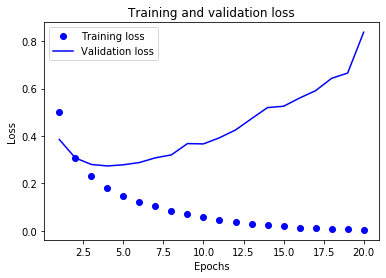

In [71]:
# we plot the loss
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

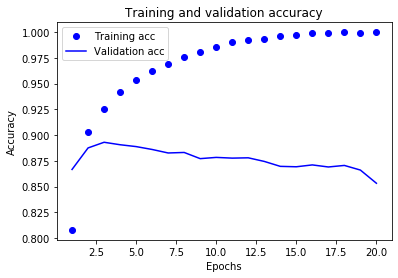

In [72]:
# we plot the accuracy
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 6. Retrain the model with 4 epochs

In [74]:
model = models.Sequential()
# input_shape = correspondes to the number of features of our input X
model.add(layers.Dense(16, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(partial_x_train, partial_y_train, epochs=4, batch_size=512, validation_data=(x_val, y_val))

# evaluation on test dataset phase
results = model.evaluate(x_test, y_test)

Epoch 1/4
30/30 [==============================] - 1s 33ms/step - loss: 0.5039 - accuracy: 0.8019 - val_loss: 0.3778 - val_accuracy: 0.8752
Epoch 2/4
30/30 [==============================] - 1s 17ms/step - loss: 0.3075 - accuracy: 0.8989 - val_loss: 0.3250 - val_accuracy: 0.8705
Epoch 3/4
30/30 [==============================] - 0s 16ms/step - loss: 0.2266 - accuracy: 0.9281 - val_loss: 0.2819 - val_accuracy: 0.8900
Epoch 4/4
782/782 [==============================] - 1s 2ms/step - loss: 0.3115 - accuracy: 0.8723


In [75]:
print(f"Results on test set. Loss: {results[0]}, Accuracy: {results[1]}")

Results on test set. Loss: 0.3114638030529022, Accuracy: 0.8722800016403198


## 7. Prediction on test set

Now we can use the trained model to predict unseen data (test data).
The ouput of the `predict()` method is going to be the likelihood of reviews being positive.


In [76]:
model.predict(x_test)

array([[0.33495593],
       [0.9985694 ],
       [0.98192954],
       ...,
       [0.11945269],
       [0.2034061 ],
       [0.58461845]], dtype=float32)